In [1]:
# !pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [2]:
G = nx.DiGraph() #define a directed graph
map_tasks = 10
reduce_tasks = 5

In [3]:
G.add_nodes_from([i for i in range(map_tasks)]) #creates the map tasks
G.add_node(map_tasks) #barreir sync for map tasks
G.add_edges_from([(i,map_tasks) for i in range(map_tasks)])  #adding edges from map taskss to the sync node
G.add_nodes_from([i+map_tasks+1 for i in range(reduce_tasks)]) #create reduce tasks
G.add_edges_from([(map_tasks, i+map_tasks+1) for i in range(reduce_tasks)]) #add edges from the sync node to the reduce tasks
G.add_node(map_tasks+reduce_tasks+1) #final node to sync the reduce tasks
G.add_edges_from([(i+map_tasks+1, map_tasks+reduce_tasks+1) for i in range(reduce_tasks)]) #adding edges from reduce tasks to end sync node

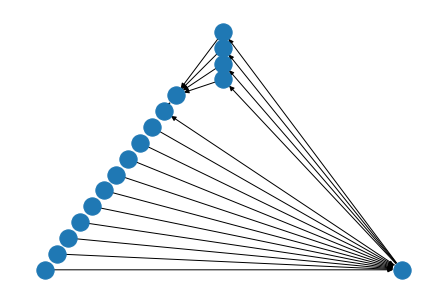

In [4]:
nx.draw_planar(G)

[range(0, 10), range(10, 11), range(11, 16), range(16, 17)]


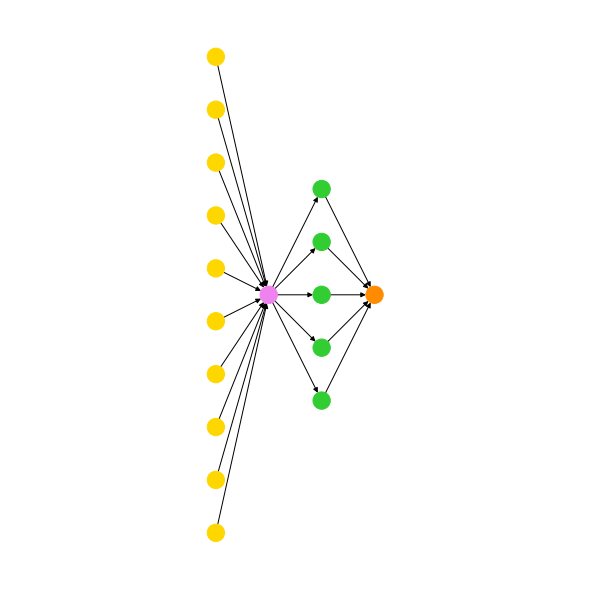

In [5]:
subset_sizes = [map_tasks, 1, reduce_tasks, 1]
subset_color = [
    "gold",
    "violet",
    "limegreen",
    "darkorange",
]


def multilayered_graph(*subset_sizes):
    extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
    layers = [range(start, end) for start, end in extents]
    print(extents)
    print(layers)
    G = nx.DiGraph()
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    return G


G = multilayered_graph(*subset_sizes)
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color, with_labels=False)
plt.axis("equal")
plt.show()

In [6]:
list(nx.topological_sort(G)) #for scheduling the tasks in the order

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [7]:
len(G.in_edges(16, data=False)) #get the incoming edges to find the dependencies

5

In [8]:
for k in (G[10].keys()): #get the out-edges of a task
  print(k)

11
12
13
14
15


In [9]:
from enum import Enum
class EventType(Enum):
  TERMINATE = 1
  FAIL = 2
  STRAGGLE = 3

In [10]:
class WorkerStatus(Enum):
  FREE = 1
  FAILED = 2
  BUSY = 3

In [11]:
class TaskStatus(Enum):
  COMPLETE = 1
  PENDING = 2
  UNASIGGNED = 3

In [12]:
class Task:

  def __init__(self, task_id: int = 0, 
                     task_parameters = {"task_type": "sort", "n_records": 1000}, 
                     task_status:TaskStatus=TaskStatus.PENDING, 
                     task_dependencies=0) -> None:
      # This task_id becomes the node number when we construct the task graph
      self.task_id = task_id
      self.status = task_status
      self.task_dependencies = task_dependencies
      self.task_parameters = task_parameters

  def debug(self):
      print("task_id: ", self.task_id)
      print("status: ", self.status)
      print("dependencies: ", self.task_dependencies)
      print("parameters: ", self.task_parameters)

In [13]:
#from traitlets.traitlets import List
from typing import List, Union
class Worker:
  def __init__(self, memory_size, network_bandwidth, disk_bandwidth, status:WorkerStatus, failure_rate, straggle_rate, task:Task = None) -> None:
      self.memory_size = memory_size
      self.network_bandwidth = network_bandwidth
      self.disk_bandwidth = disk_bandwidth
      self.status = status
      self.task = task
      self.failure_rate = failure_rate
      self.straggle_rate = straggle_rate
      
      self.bandwidth_status = {} # {Worker: bandwidth_usage}
      self.current_bandwidth = 0

  def processing_time(self)->List[Union[EventType,int]]:
    total_processing_time = 0

    total_processing_time += self.networking_time()
    total_processing_time += self.disk_time()

    task_parameters = self.task.task_parameters
    # print(task_parameters)
    #use task and worker parameters to figure out the procesing time for the worker
    if task_parameters["task_type"] == "sort":
      total_processing_time += task_parameters["n_records"] * np.log(task_parameters["n_records"])

    if task_parameters["task_type"] == "grep":
      total_processing_time += task_parameters["n_records"]

    return [EventType.TERMINATE, total_processing_time]

  def networking_time(self):
    # TODO: Have this function actually calculate networking time given its attributes
    return 5

  def disk_time(self):
    # TODO: Have this function actually calculate networking time given its attributes
    return 5


In [14]:
sort_task = Task()
worker = Worker(memory_size=100, network_bandwidth=10, disk_bandwidth=10, status=WorkerStatus.FREE, failure_rate=0.01, straggle_rate=0.01, task=sort_task)
print(worker.processing_time())
grep_task = Task(task_parameters={"task_type":"grep", "n_records":10})
worker.task = grep_task
print(worker.processing_time())
# Processing time works correctly after changing task assigned to worker!

[<EventType.TERMINATE: 1>, 6917.755278982137]
[<EventType.TERMINATE: 1>, 20]


In [15]:
class Event:
  def __init__(self, time =0, event_type:EventType = None, worker:Worker = None) -> None:
      self.time = time
      self.event_type = event_type 
      self.worker = worker

  def __eq__(self, other):
      return self.time == other.time
    
  def __gt__(self, other):
      return self.time > other.time

  def __lt__(self, other):
    return self.time < other.time
    

In [28]:
class TaskGraph(nx.DiGraph):
    def __init__(self, *task_topology):
        super().__init__()
        self.subset_color = [
            "gold",
            "violet",
            "limegreen",
            "darkorange",
        ]
        extents = nx.utils.pairwise(itertools.accumulate((0,) + task_topology))
        print(extents)
        layers = [range(start, end) for start, end in extents]
        print(layers)
        print(self)
        for (i, layer) in enumerate(layers):
            # list of Task objects
            task_list = [dict(task=Task(task_id=t_id)) for t_id in layer]
            node_list = list(zip(list(layer), task_list))
            print(node_list)
            self.add_nodes_from(node_list, layer=i)
        for layer1, layer2 in nx.utils.pairwise(layers):
            self.add_edges_from(itertools.product(layer1, layer2))

    def debug(self):
        print("debugging graph\n")
        for node in self.nodes:
            self.nodes[node]["task"].debug()
    
    def print_graph(self):
        color = [subset_color[data["layer"]] for v, data in self.nodes(data=True)]
        pos = nx.multipartite_layout(self, subset_key="layer")
        plt.figure(figsize=(8, 8))
        nx.draw(self, pos, node_color=color, with_labels=False)
        plt.axis("equal")
        plt.show()

[range(0, 10), range(10, 12), range(12, 15), range(15, 20)]
[(0, {'task': <__main__.Task object at 0x7fb69f002810>}), (1, {'task': <__main__.Task object at 0x7fb69f04c4d0>}), (2, {'task': <__main__.Task object at 0x7fb69ee27190>}), (3, {'task': <__main__.Task object at 0x7fb69f05ae90>}), (4, {'task': <__main__.Task object at 0x7fb69ee211d0>}), (5, {'task': <__main__.Task object at 0x7fb69ee21350>}), (6, {'task': <__main__.Task object at 0x7fb69ee21450>}), (7, {'task': <__main__.Task object at 0x7fb69ee21110>}), (8, {'task': <__main__.Task object at 0x7fb69ee21e10>}), (9, {'task': <__main__.Task object at 0x7fb69ee21190>})]
[(10, {'task': <__main__.Task object at 0x7fb69ee21090>}), (11, {'task': <__main__.Task object at 0x7fb69ee21f50>})]
[(12, {'task': <__main__.Task object at 0x7fb69ee21b90>}), (13, {'task': <__main__.Task object at 0x7fb69ee21dd0>}), (14, {'task': <__main__.Task object at 0x7fb69ee21890>})]
[(15, {'task': <__main__.Task object at 0x7fb69ee21ad0>}), (16, {'task': <__m

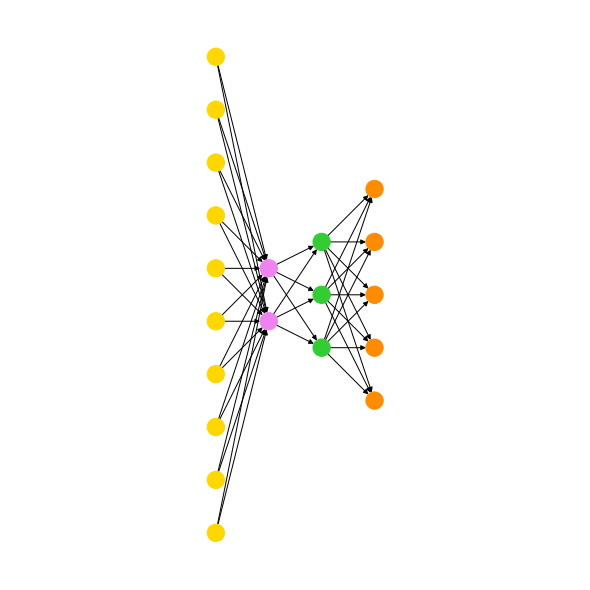

[range(0, 10), range(10, 12), range(12, 15), range(15, 20)]
TaskGraph with 0 nodes and 0 edges
[(0, {'task': <__main__.Task object at 0x7fb69ed18710>}), (1, {'task': <__main__.Task object at 0x7fb69ed186d0>}), (2, {'task': <__main__.Task object at 0x7fb69ed18690>}), (3, {'task': <__main__.Task object at 0x7fb69ed18410>}), (4, {'task': <__main__.Task object at 0x7fb69ed183d0>}), (5, {'task': <__main__.Task object at 0x7fb69ed18290>}), (6, {'task': <__main__.Task object at 0x7fb69ed18250>}), (7, {'task': <__main__.Task object at 0x7fb69ed18210>}), (8, {'task': <__main__.Task object at 0x7fb69effcf50>}), (9, {'task': <__main__.Task object at 0x7fb69ed18310>})]
[(10, {'task': <__main__.Task object at 0x7fb69ee21c90>}), (11, {'task': <__main__.Task object at 0x7fb69ee21c10>})]
[(12, {'task': <__main__.Task object at 0x7fb69ed9e550>}), (13, {'task': <__main__.Task object at 0x7fb69ed0af50>}), (14, {'task': <__main__.Task object at 0x7fb69ed0aed0>})]
[(15, {'task': <__main__.Task object at 0x

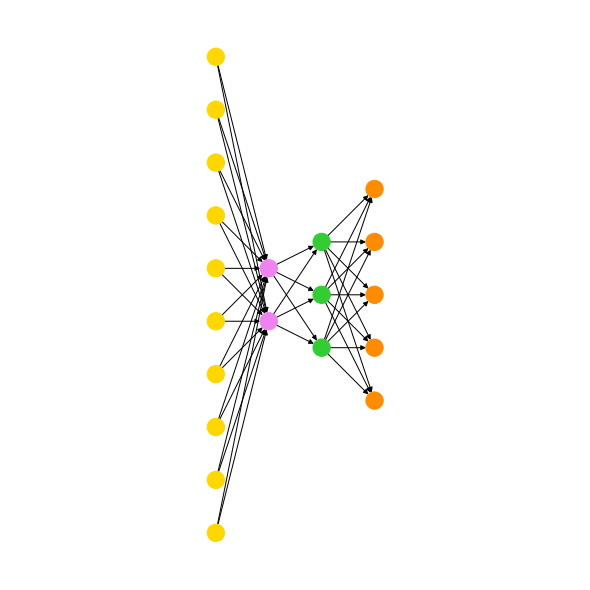

In [29]:
# structure of the task graph, number of tasks per layer
task_topology = [10,2,3,5]

def build_task_graph(*task_topology):
    extents = nx.utils.pairwise(itertools.accumulate((0,) + task_topology))
    print(extents)
    layers = [range(start, end) for start, end in extents]
    print(layers)
    G = nx.DiGraph()
    for (i, layer) in enumerate(layers):
        # list of Task objects
        task_list = [dict(task=Task(task_id=t_id)) for t_id in layer]
        node_list = list(zip(list(layer), task_list))
        print(node_list)
        G.add_nodes_from(node_list, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    return G

def debug(g: nx.DiGraph):
    print("debugging graph\n")
    for node in g.nodes:
        g.nodes[node]["task"].debug()

def print_graph(g: nx.DiGraph):
    subset_color = [
        "gold",
        "violet",
        "limegreen",
        "darkorange",
    ]
    color = [subset_color[data["layer"]] for v, data in g.nodes(data=True)]
    pos = nx.multipartite_layout(g, subset_key="layer")
    plt.figure(figsize=(8, 8))
    nx.draw(g, pos, node_color=color, with_labels=False)
    plt.axis("equal")
    plt.show()


G = build_task_graph(*task_topology)
print_graph(G)

G2 = TaskGraph(*task_topology)
G2.print_graph()

In [30]:

from queue import Queue, PriorityQueue

class Scheduler:
  
  def __init__(self, task_graph: TaskGraph, Workers: List[Worker]) -> None:
    self.G = task_graph # Graph of tasks 
    self.Workers = Workers # List of workers

  def simulate(self) -> None:

      # choose a first task from the head of the queue
      # task is ready
      # hashmap of workers which stores the busy/free workers
      # assign task to the worker
      # create an event, some time units for the task insert the event in priority queue


    task_queue = Queue() #task queue as a topologically sorted task graph
    event_queue = PriorityQueue() #priority queue for events 
    free_worker_list = self.Workers #list to store the free workers
    
    print(self.G.nodes)
    #initiliaze the task dependency numbers
    for node_number in self.G.nodes:
      # TODO: add task_dependencies to TaskGraph()
      node = G.nodes[node_number]
      node["task"].task_dependencies = G.in_degree(node_number)
      if (node["task"].task_dependencies == 0):
        task_queue.put(node["task"]) #add the ready tasks to the queue

    debug(self.G)

    print("starting to work through task_queue.\n")
    while not task_queue.empty(): #iterate through the tasks that are ready to execute
      task = task_queue.get() #get the first task from the queue
      if len(free_worker_list) == 0:
        break
      worker = free_worker_list.pop() #remove a worker from the free_list
      worker.task = task #assign the task to the worker
      worker.status = WorkerStatus.BUSY
      event_type, task_process_time = worker.processing_time() #get the approximate processing time and the probabilistic fate of the worker
      event = Event(task_process_time, event_type, worker) #create an event with the above parameters
      event_queue.put(event) #add the event to the event queue

    print("starting to work through event_queue.\n")
    while not event_queue.empty():
      # print("processing an event")
      event = event_queue.get()
      # print(event)
      # print("processed an event")
      if (event.event_type == EventType.TERMINATE):
        #print("in here")
        worker = event.worker
        worker.task.status = TaskStatus.COMPLETE
        for k in (G[worker.task.task_id].keys()): #get the out-edges of a task
          G.nodes[k]["task"].task_dependencies -= 1 #decrement the dependecies of all out_going edges
          if (G.nodes[k]["task"].task_dependencies == 0): #if dependencies of a task are 0, it is ready to be added into the task queue
            task_queue.put(G.nodes[n]["task"])
        # print("got out of for loop")
        worker.task = None #remove the task from the worker
        worker.status = WorkerStatus.FREE #mark the status of the worker to free
        free_worker_list.append(worker) #add the worker to the free list
    
    print(f"Event queue: {event_queue.queue}")
    return None
    

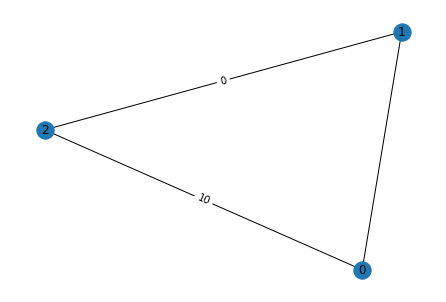

In [32]:
import copy

sample_workers = [
    Worker(memory_size=100, network_bandwidth=10, disk_bandwidth=10, status=WorkerStatus.FREE, failure_rate=0.01, straggle_rate=0.01, task=None),
    Worker(memory_size=100, network_bandwidth=10, disk_bandwidth=10, status=WorkerStatus.FREE, failure_rate=0.01, straggle_rate=0.01, task=None),
    Worker(memory_size=100, network_bandwidth=10, disk_bandwidth=10, status=WorkerStatus.FREE, failure_rate=0.01, straggle_rate=0.01, task=None)]
    
class WorkerGraph():
    G = None
    workers = []

    def __init__(self, workers):
        G = nx.Graph() #define a graph
        self.workers = workers
        idxs = range(len(workers))
        G.add_nodes_from(idxs)
        G.add_edges_from(itertools.combinations(idxs,2)) # add all combinational pairs
        self.G = G
        
    def print_graph(self):
        labels = nx.get_edge_attributes(self.G,'bandwidth')
        pos=nx.spring_layout(self.G)
        nx.draw(self.G, pos, with_labels=True)
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=labels)
        
    def request(self, src_worker, dest_worker):
        src_worker_idx, dest_worker_idx = self.workers.index(src_worker), self.workers.index(dest_worker)
        # start with the easiest one
        # request as much as both source and dest can afford at the same time
        bandwidth = max(min(src_worker.network_bandwidth - src_worker.current_bandwidth,
                        dest_worker.network_bandwidth - dest_worker.current_bandwidth), 
                        0)

        # update bandwidth_status hashmap
        src_worker.bandwidth_status[dest_worker] = bandwidth
        dest_worker.bandwidth_status[src_worker] = bandwidth
        src_worker.current_bandwidth += bandwidth
        dest_worker.current_bandwidth += bandwidth
        self.G.edges[src_worker_idx,dest_worker_idx]['bandwidth']=bandwidth
        return bandwidth

workerG = WorkerGraph(sample_workers)
workerG.request(sample_workers[0], sample_workers[2]) # request 0->1, get 10
workerG.request(sample_workers[1], sample_workers[2]) # request 0->2, get 0 since 2 is using all of its bandwidth
workerG.print_graph()


In [33]:
''' class Simulator():

    def __init__(self, s: Scheduler):
        self.scheduler = s 

    
 '''


# DON"T NEED CUZ WE PUT TASKS IN THE  nx.DiGraph dictionary
# class TaskGraph():
#     def __init__(self, task_graph:nx.DiGraph):
#         self.graph = task_graph
#         for 

#         for n in range(len( self.G.nodes)):
#             # TODO: add task_dependencies to TaskGraph()
#             G[n].task_dependencies = G.in_degree(n)
#             if (G[n].task_dependencies == 0):
#                 task_queue.put(G[n]) #add the ready tasks to the queue
#         task_dependencies: List[List[Task]]


' class Simulator():\n\n    def __init__(self, s: Scheduler):\n        self.scheduler = s \n\n    \n '

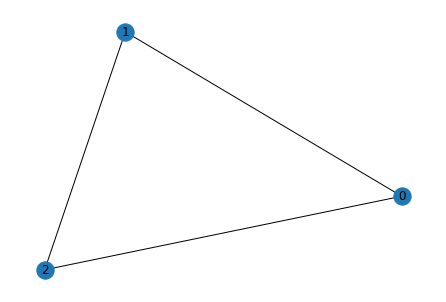

In [34]:
# test script

sample_workers = [
    Worker(memory_size=100, network_bandwidth=10, disk_bandwidth=10, status=WorkerStatus.FREE, failure_rate=0.01, straggle_rate=0.01, task=None),
    Worker(memory_size=100, network_bandwidth=10, disk_bandwidth=10, status=WorkerStatus.FREE, failure_rate=0.01, straggle_rate=0.01, task=None),
    Worker(memory_size=100, network_bandwidth=10, disk_bandwidth=10, status=WorkerStatus.FREE, failure_rate=0.01, straggle_rate=0.01, task=None)]

workerG = WorkerGraph(sample_workers)
workerG.print_graph()



In [35]:
scheduler = Scheduler(G2, sample_workers)
scheduler.simulate()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
debugging graph

task_id:  0
status:  TaskStatus.PENDING
dependencies:  0
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  1
status:  TaskStatus.PENDING
dependencies:  0
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  2
status:  TaskStatus.PENDING
dependencies:  0
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  3
status:  TaskStatus.PENDING
dependencies:  0
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  4
status:  TaskStatus.PENDING
dependencies:  0
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  5
status:  TaskStatus.PENDING
dependencies:  0
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  6
status:  TaskStatus.PENDING
dependencies:  0
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  7
status:  TaskStatus.PENDING
dependencies:  0
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  8
status:  Tas

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=26c72990-d4fd-4f51-a2d1-b4fb7127844f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>